In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.datasets as sk_data
from sklearn.cluster import KMeans

#import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# Clustering III: Hierarchical Clustering

Today we will look at a fairly different approach to clustering.

So far, we have been thinking of clustering as finding a __partition__ of our dataset.

That is, a set of nonoverlapping clusters, in which each data item is in one cluster.

However, in many cases, the notion of a strict partition is not as useful.

## How Many Clusters?

How many clusters are there?

In [63]:
X_rand, y_rand = sk_data.make_blobs(n_samples=[100, 100, 250, 70, 75, 80], centers = [[1, 2], [1.5, 1], [3, 2], [1.75, 3.25], [2, 4], [2.25, 3.25]], n_features = 2,
                          center_box = (-10.0, 10.0), cluster_std = [.2, .2, .3, .1, .15, .15], random_state = 0)
df_rand = pd.DataFrame(np.column_stack([X_rand[:, 0], X_rand[:, 1], y_rand]), columns = ['X', 'Y', 'label'])
df_rand = df_rand.astype({'label': 'int'})
df_rand['label2'] = [{0: 0, 1: 1, 2: 2, 3: 3, 4: 3, 5: 3}[x] for x in df_rand['label']]
df_rand['label3'] = [{0: 0, 1: 0, 2: 1, 3: 2, 4: 2, 5: 2}[x] for x in df_rand['label']]
kmeans = KMeans(init = 'k-means++', n_clusters = 3, n_init = 100)
df_rand_clust['label'] = kmeans.fit_predict(df_rand[['X', 'Y']])

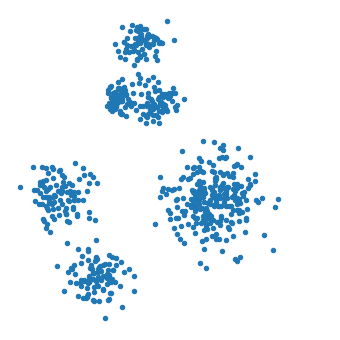

In [88]:
df_rand.plot('X', 'Y', kind = 'scatter', colormap='viridis', 
                   colorbar = False, figsize = (6, 6))
plt.axis('square')
plt.axis('off');

__Three clusters?__

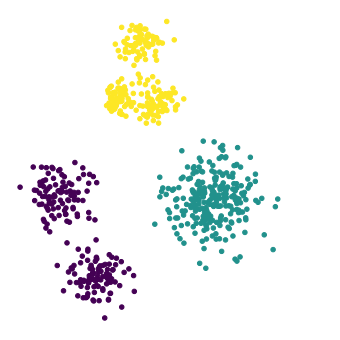

In [89]:
df_rand.plot('X', 'Y', kind = 'scatter', c = 'label3', colormap='viridis', 
                   colorbar = False, figsize = (6, 6))
plt.axis('square')
plt.axis('off');

__Four clusters?__

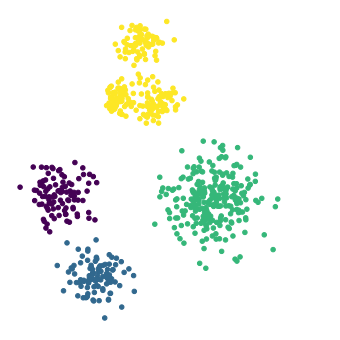

In [82]:
df_rand.plot('X', 'Y', kind = 'scatter', c = 'label2', colormap='viridis', 
                   colorbar = False, figsize = (6, 6))
plt.axis('square')
plt.axis('off');

__Six clusters?__

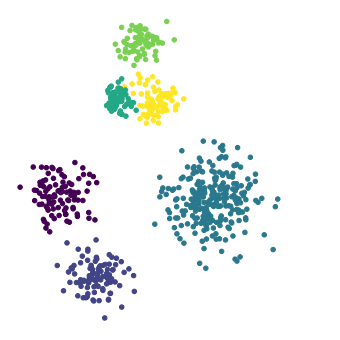

In [83]:
df_rand.plot('X', 'Y', kind = 'scatter', c = 'label', colormap='viridis', 
                   colorbar = False, figsize = (6, 6))
plt.axis('square')
plt.axis('off');

This dataset shows clustering on __multiple scales.__

To fully capture the structure in this dataset, two things are needed:
1. Capturing the differing clusters depending on the scale
2. Capturing the containment relations -- which clusters lie within other clusters

These observations motivate the notion of __hierarchical__ clustering.

In hierarchical clustering, we move away from the __partition__ notion of $k$-means, 

and instead capture a more complex arrangement that includes containment of one cluster within another.

## Hierarchical Clustering

A hierarchical clustering produces a set of __nested__ clusters organized into a tree.

A hierarchical clustering is visualized using a __dendrogram__ 

* A tree-like diagram that records the containment relations among clusters.

<center>

<img src="./figs/L08-dendrogram.png" width="600px">

</center>

### Strengths of Hierarchical Clustering